In [1]:
import torch
from torch import nn
from torch.utils.data import (Dataset, DataLoader)

import torchvision
from torchinfo import summary
from torchvision import transforms
from PIL import Image

import numpy as np
import warnings
import os
import glob
from tqdm.auto import tqdm

from typing import Dict, List, Tuple
import wandb

from sklearn.model_selection import train_test_split

c:\Users\Seo\anaconda3\envs\Hackaton\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


아래의 CLASSES의 이름은 다운 받은 폴더의 이름이 일치해야 합니다. ex) data/train

In [2]:
# 우리가 분류할 4개의 클래스
#CLASSES = [ 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented' ]
classes = []

config들.

In [3]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 16
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = "/data/"
    TRAIN_PATH = '/data/train/'
    TEST_PATH = '/data/test/'
    
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [4]:
save_dir = 'saved'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

result_dir = 'result'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

학습에 필요한 상수 정의

In [8]:
from pathlib import Path

# 학습에 필요한 상수들을 정의 합니다.
IMG_SHAPE = (224, 224, 3)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 10

# 각 이미지의 기본 주소
BASE_PATH = './data/'
images_dir = Path(BASE_PATH).expanduser()
print(images_dir)

data


내 드라이브 파일 마운트하고, 폴더 정보 읽어오기

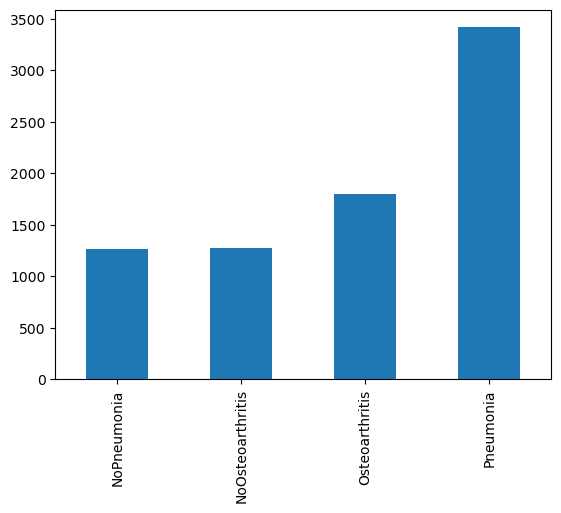

NoPneumonia         1267
NoOsteoarthritis    1273
Osteoarthritis      1799
Pneumonia           3419
dtype: int64


In [11]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# 모델 학습에 사용할 데이터 정보를 설정합니다.
class_list = []
num_list = []

# IMAGE_BASE_PATH = './data/'
train_path = BASE_PATH + 'train/'
for folder in os.listdir(train_path):
    classes.append(folder)
    folder_size = len(os.listdir(train_path+folder))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

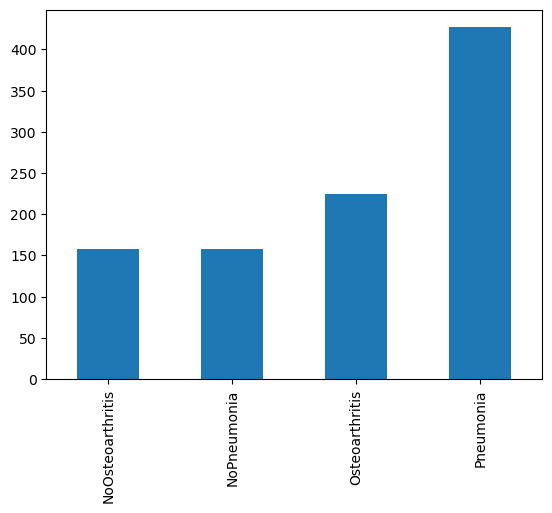

NoOsteoarthritis    158
NoPneumonia         158
Osteoarthritis      224
Pneumonia           427
dtype: int64


In [12]:
# 모델 학습 검증에 사용할 데이터 내용 입니다.

class_list = []
num_list = []

#IMAGE_BASE_PATH = './data/'
valid_path = BASE_PATH + 'test/'
for folder in os.listdir(valid_path):
    folder_size = len(os.listdir(valid_path+folder))
    # print('{:<15} : {}'.format(folder,folder_size))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

In [13]:
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

In [14]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]

def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Return df
    return df

In [18]:
# Build the DataFrames
# train_df = build_df(train_images, generate_labels(train_images))
train_df = build_df(train_images, train_images)
# test_df = build_df(test_images, generate_labels(test_images))
test_df = build_df(test_images, test_images)

functions for display. 

In [16]:
def _load(image_path, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(image_path)
    
    if as_tensor:
        converter = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Grayscale()
        ])
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

In [19]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df.index, 
        train_df.label, 
        test_size=0.20,
        stratify=train_df.label,
        random_state=CFG.SEED
    )
)

# Get training and remaining data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
# train_new_df.shape, val_df.shape

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Image Transform

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=30,),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [ ]:
class BrainTumorMRIDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

Build Custom Datasets

In [ ]:
# Build train dataset
train_ds = BrainTumorMRIDataset(train_new_df, transform=train_transforms)

# Build validation dataset
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)

# Build test dataset
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)

Build DataLoaders from Custom Datasets

In [ ]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

Transfer Learning 하기

In [ ]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [ ]:
class EfficientNetV2SModel(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-small', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2SModel, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [ ]:
def get_effiecientnetv2_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision.models.EfficientNet_V2_L_Weights.DEFAULT)
    
    # Get model and push to device
    model = (
        torchvision.models.efficientnet_v2_l(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
        
    return model

In [ ]:
def get_effiecientnetv2_s_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
    
    # Get model and push to device
    model = (
        torchvision.models.efficientnet_v2_s(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
        
    return model

In [ ]:
# Get EfficientNet v2 model
backbone_model = get_effiecientnetv2_model(CFG.DEVICE)

In [ ]:
backbone_model = get_effiecientnetv2_s_model(CFG.DEVICE)

In [ ]:
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE
}

# Generate Model
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    efficientnet_model = nn.DataParallel(efficientnet_model)

In [ ]:
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-small',
    'device'            : CFG.DEVICE
}

# Generate Model
efficientnet_model = EfficientNetV2SModel(**efficientnetv2_params)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    efficientnet_model = nn.DataParallel(efficientnet_model)

In [ ]:
# View model summary
summary(
    model=efficientnet_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Training Model

- define Loss & Optimizer

In [ ]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.AdamW(
    efficientnet_model.parameters(),
    lr=CFG.LR
)

Define Epoch Execution (Train Step)

In [ ]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

Define Evaluation Step

In [ ]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

Construct Training Loop

In [ ]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # `wandb` 초기화
    #wandb.init(project="2024_Hackaton", entity="tjwjddn980117")

    # 모델과 옵티마이저를 `wandb`에 로깅하기 위해 추가
    #wandb.watch(model, log="all")

    # 최고 평가 정확도를 추적하기 위한 변수 초기화
    best_eval_accuracy = 0.0

    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }

    if os.path.exists(f'{save_dir}/best_model_weights.pth'):
        model_weights = torch.load(f'{save_dir}/best_model_weights.pth')
        model.load_state_dict(model_weights)
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
        
        if (epoch // 20) == 0:
            torch.save(model.state_dict(), f'{save_dir}/{epoch}_model_weights.pth')
            
        # Check for improvement
        if eval_acc > best_eval_accuracy:
            print(f"새로운 최고 평가 정확도: {eval_acc:.4f}, 이전: {best_eval_accuracy:.4f}")
            best_eval_accuracy = eval_acc
            # 모델 가중치 저장
            torch.save(model.state_dict(), f'{save_dir}/best_model_weights.pth')
            print("모델 가중치가 'best_model_weights.pth'에 저장되었습니다.")
            
    # Return Session Metrics
    return session

Train EfficientNet Model

In [ ]:
# Train the model 
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_session_config = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

efficientnet_session_history = train(**efficientnet_session_config)

In [ ]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [ ]:
# Generate test sample probabilities 
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.DEVICE)

In [ ]:
# Generate test sample preditions 
efficientnet_test_preds = np.argmax(efficientnet_test_probs, axis=1)